# Seminar Introduction

Welcome to our seminar! Today we will delve into several key concepts that will help you write more structured, flexible, and intelligent code, especially in the context of system modeling and control.

The main topics we will cover:

1.  **Using Abstract Classes for Code Structuring:** We will learn how abstract classes and methods help define common interfaces and contracts for different system components. This promotes better code organization, reusability, and simplifies further project expansion and maintenance. We will see how this approach allows for the creation of flexible modeling frameworks.

2.  **Example: The One-Dimensional "Lighthouse Keeper" System:** To illustrate the practical application of the discussed concepts, we will examine a simple yet illustrative one-dimensional dynamic system. Analyzing this system will help us understand how theoretical approaches apply to specific modeling and control tasks.

3.  **Adaptive Control:** We will study a simple parameter adaptation scheme for system control. This is an introduction to the exciting field of adaptive control, where systems can "learn" and adjust their behavior in response to changes in the environment or the system itself. We will review the basic principles and algorithms that enable such behavior.

Throughout the seminar, we will combine theoretical discussions with practical code examples so that you can not only understand the concepts but also learn to apply them in your own projects. Get ready for an interesting journey into the world of structured programming and control fundamentals!


## Abstract Classes: Defining a Blueprint

In object-oriented programming, an abstract class serves as a blueprint for other classes. It defines a common structure and a set of methods that must be implemented by any concrete (i.e., non-abstract) subclass that inherits from it. You cannot create an instance of an abstract class itself; its purpose is solely to be inherited from. Abstract classes often contain a mix of implemented methods (providing default behavior) and abstract methods (which have no implementation and must be overridden by subclasses). This enforces a certain standard or contract across different implementations, ensuring that all subclasses share a common interface and core functionalities, which promotes code consistency and reusability.

## The `System` Abstract Class

In our seminar, we introduce the `System` abstract class. This class is designed to represent a general dynamic system. It defines the essential characteristics and behaviors that any specific system we model must possess. By declaring methods like `get_state`, `set_state`, `get_state_derivative`, and `step` as abstract, we mandate that any class inheriting from `System` (like our 'Lighthouse Keeper' example later) must provide its own specific implementation for these core operations. This approach ensures that regardless of the particular system's dynamics, we can interact with it through a consistent interface, for instance, to simulate its evolution over time or to analyze its properties like energy, which are also defined as abstract methods (`get_kinetic_energy`, `get_potential_energy`, `get_energy`). This structure makes our simulation and control code more generic and adaptable to different systems.


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from abc import abstractmethod, ABC

In [32]:
class System(ABC):
    @abstractmethod
    def get_state(self) -> np.ndarray:
        """Returns the current state vector."""
        pass

    @abstractmethod
    def set_state(self, state: np.ndarray):
        """Sets the current state vector."""
        pass

    @abstractmethod
    def get_state_derivative(self, control_input: float, state: np.ndarray | None = None, t: float | None = None) -> np.ndarray:
        """Computes the derivative of the state vector."""
        pass

    @abstractmethod
    def step(self, dt: float, control_input: float):
        """Performs one simulation step using the Euler method."""
        pass

    @abstractmethod
    def get_kinetic_energy(self, state: np.ndarray | None = None) -> float:
        """
        Computes the kinetic energy of the system.

        Args:
            state: State vector. If None, uses the current state.

        Returns:
            Kinetic energy.
        """
        pass

    @abstractmethod
    def get_potential_energy(self, state: np.ndarray | None = None) -> float:
        """
        Computes the potential energy of the system.

        Args:
            state: State vector. If None, uses the current state.

        Returns:
            Potential energy.
        """
        pass

    @abstractmethod
    def get_energy(self, state: np.ndarray | None = None) -> float:
        """
        Computes the total energy of the system.

        Args:
            state: State vector. If None, uses the current state.

        Returns:
            Total energy.
        """
        pass 

## The Lighthouse Keeper System: Dynamics

The `LightHouseKeeper` class implements the `System` interface for a simple one-dimensional physical system. Imagine a lighthouse keeper who can move along a straight track (the x-axis). Their state is defined by their position $x$ and velocity $\dot{x}$.

**State Vector:**
The state of the system at any time $t$ is represented by the vector:
$$
\mathbf{s}(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix}
$$

**Equations of Motion:**
The evolution of the system over time is governed by the following set of first-order ordinary differential equations (ODEs), derived from the second-order dynamics:
$$
\frac{d\mathbf{s}}{dt} = \begin{bmatrix} \dot{x} \\ \ddot{x} \end{bmatrix}
$$
Where:
- $\dot{x}$ is the rate of change of position (velocity).
- $\ddot{x}$ is the rate of change of velocity (total acceleration).

**Control Input and Wind:**
The controller provides a desired acceleration, which we denote as $a$. This represents our **control input**. However, the keeper has physical limitations, so the actual acceleration they can apply is clipped to a maximum magnitude $A_{max}$ (`control_limit` in the code). 
Additionally, there's an external wind force causing a constant acceleration $w$ (`wind_acceleration_true` in the code).

**Total Acceleration:**
The total acceleration $\ddot{x}$ acting on the keeper is the sum of the clipped control input and the wind acceleration:
$$
\ddot{x} = \text{clip}(a, -A_{max}, A_{max}) + w
$$
The `clip` function ensures the control contribution stays within $[-A_{max}, A_{max}]$.

**Putting it Together:**
The complete state derivative equations are:
$$
\begin{cases}
\frac{dx}{dt} = \dot{x} \\
\frac{d\dot{x}}{dt} = \ddot{x} = \text{clip}(a, -A_{max}, A_{max}) + w
\end{cases}
$$
These equations describe how the position $x$ and velocity $\dot{x}$ of the lighthouse keeper change over time based on the control input $a$ (provided by the controller) and the external wind $w$.


In [33]:

class LightHouseKeeper(System): # Make sure the base class System is available
    def __init__(self, initial_position=0, initial_velocity=0, control_limit=1, wind_acceleration=1/2, mass=1.0):
        """
        Initialize the Lighthouse Keeper (1D) system.

        Args:
            initial_position (float): Initial position.
            initial_velocity (float): Initial velocity.
            control_limit (float): Limit on the control input (acceleration) magnitude.
            mass (float): Mass of the keeper (for energy calculations). Default: 1.0.
        """
        # System state: [x, vx]
        self._state = np.array([initial_position, initial_velocity], dtype=float)
        self.control_limit = control_limit
        self.mass = mass

        # True wind acceleration (unknown to the controller/estimator)
        self.wind_acceleration_true = wind_acceleration

    # --- Implementation of System abstract methods --- 

    def get_state(self) -> np.ndarray:
        """Returns the current state vector [x, vx]."""
        return self._state

    def set_state(self, state: np.ndarray):
        """Sets the current state vector [x, vx]."""
        if state.shape != (2,):
            raise ValueError("State must be a NumPy array of shape (2,)")
        self._state = state.astype(float)

    def get_state_derivative(self, control_input: float, state: np.ndarray | None = None, t: float | None = None) -> np.ndarray:
        """
        Computes the derivative of the state vector [vx, ax_total].
        Uses the true wind value internally.

        Args:
            control_input (float): Control acceleration from the controller.
            state (np.ndarray | None): The state at which to compute the derivative. 
                                      If None, uses the current system state. Default: None.
            t (float | None): Current time (not used in this simple model). Default: None.

        Returns:
            np.ndarray: State derivative [vx, ax_total].
        """
        current_state = self._state if state is None else state
        position = current_state[0]
        velocity = current_state[1]

        # Apply the limit to the control acceleration provided by the controller
        applied_control = np.clip(control_input, -self.control_limit, self.control_limit) #edit

        # Total acceleration = applied control + true wind
        total_acceleration = applied_control + self.wind_acceleration_true #edit

        d_position = velocity
        d_velocity = total_acceleration

        return np.array([d_position, d_velocity])

    def step(self, dt: float, control_input: float):
        """Performs one simulation step using the Euler method."""
        state_derivative = self.get_state_derivative(control_input, self._state)

        self._state += state_derivative * dt #edit
        # We might want to return the new state, although the base class doesn't require it
        # return self._state 

        return self._state

    def get_kinetic_energy(self, state: np.ndarray | None = None) -> float:
        """
        Computes the kinetic energy: 0.5 * m * v^2.
        """
        current_state = self._state if state is None else state
        velocity = current_state[1]
        return 0.5 * self.mass * velocity**2 #edit

    def get_potential_energy(self, state: np.ndarray | None = None) -> float:
        """
        Computes the potential energy. Assuming zero potential energy at x=0.
        Set to 0 for now, as it's not clearly defined for a lighthouse keeper.
        """
        # current_state = self._state if state is None else state
        # position = current_state[0]
        # Example: return self.mass * 9.81 * position # If gravity matters
        current_state = self._state if state is None else state
        x = current_state[0]
        return self.mass * 9.81 * x

    def get_energy(self, state: np.ndarray | None = None) -> float:
        """
        Computes the total energy (Kinetic + Potential).
        """
        current_state = self._state if state is None else state
        return self.get_kinetic_energy(current_state) + self.get_potential_energy(current_state)

    # --- Specific Methods for LightHouseKeeper --- 

    def set_true_wind(self, wind_accel: float):
        """Sets the true wind value (for simulation)."""
        self.wind_acceleration_true = wind_accel



## Testing with a Zero Controller

Before implementing more complex control strategies, it's often useful to test the system simulation with a very simple controller: the `ZeroController`. 

**Purpose:** The primary goal of using a `ZeroController` is to observe the system's *uncontrolled* or *open-loop* behavior. This helps verify that the system dynamics (as implemented in the `LightHouseKeeper` class) are correct and behave as expected under the influence of only external forces (like the wind in our case).

**Implementation:** A `ZeroController` is straightforward. Its control logic simply outputs a control signal of 0 at every time step, regardless of the system's state.
$$ a = 0 $$

**Expected Behavior:** When the `LightHouseKeeper` system is simulated using the `ZeroController`, the control input $a$ will always be 0. Therefore, the clipping function $\text{clip}(a, -A_{max}, A_{max})$ will also output 0. The system dynamics then simplify to:
$$
\begin{cases}
\frac{dx}{dt} = \dot{x} \\
\frac{d\dot{x}}{dt} = \ddot{x} = 0 + w = w
\end{cases}
$$
This means the lighthouse keeper will experience a constant acceleration equal to the wind acceleration $w$. Simulating this should result in parabolic motion (constant acceleration) in the position $x$, which we can plot and check against analytical calculations.


In [34]:
from abc import ABC, abstractmethod

class Controller(ABC):
    @abstractmethod
    def compute_control(self, system: System | None = None, t: float | None = None) -> float:
        """Computes the control input."""
        pass

In [35]:
# Definition of ZeroController (make sure it returns 0.0 as discussed):
class ZeroController(Controller):
    def compute_control(self, system: System | None = None, t: float | None = None) -> float:
        """
        Returns zero control.

        Returns:
            float: 0.0 - zero control value
        """
        return 0.0

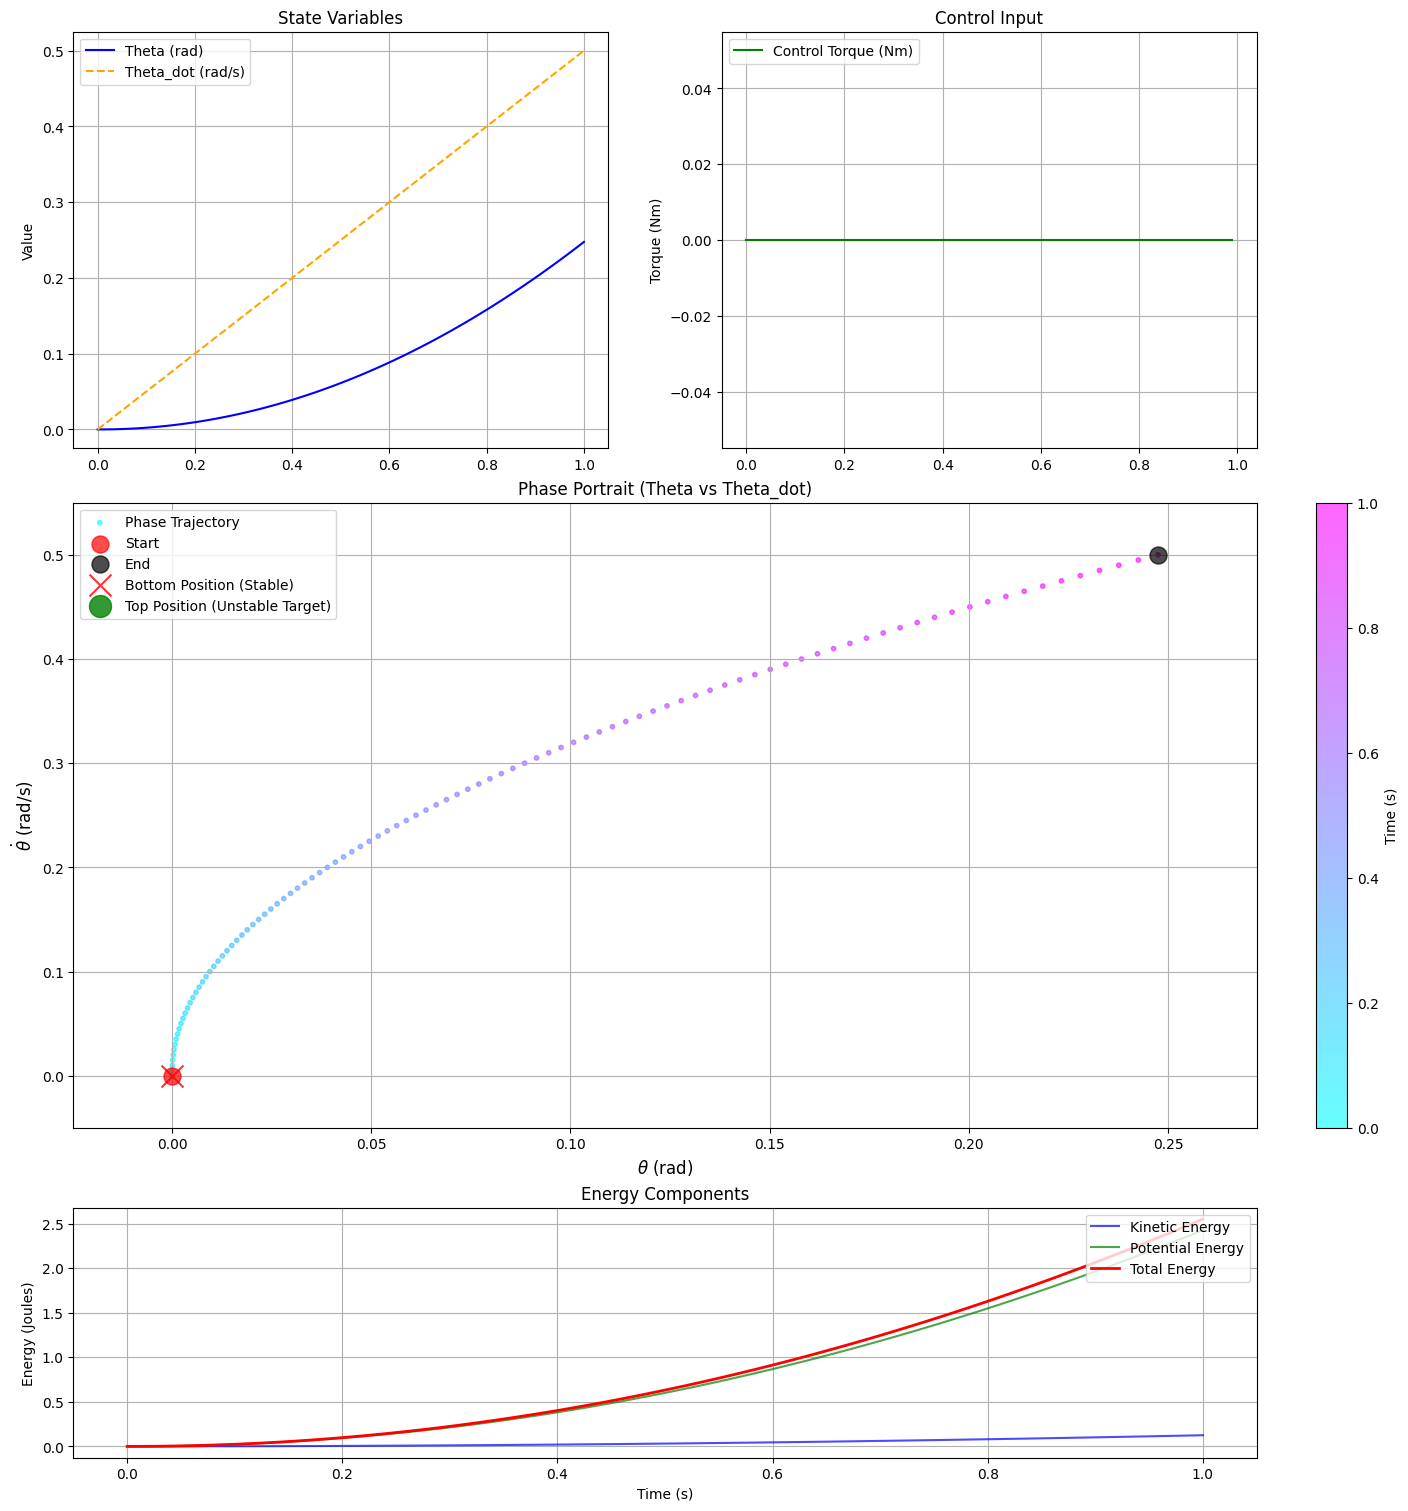

In [36]:
from src.simulator import Simulator

# System initialization
zero_controller = ZeroController()
keeper = LightHouseKeeper(initial_position=0,
                          initial_velocity=0,
                          control_limit=1,
                          mass=1,
                          wind_acceleration=1/2)

# Simulator creation
dt = 0.01  # Time step for simulation
num_steps = 100
simulator = Simulator(system=keeper,
                      controller=zero_controller,
                      dt=dt,
                      num_steps=num_steps)


# Running the simulation
simulator.run()

# Plotting results using the simulator's method
simulator.plot_results() # Используем встроенный метод симулятора

## Implementing Linear Control (PD Controller)

Now, let's move beyond the simple `ZeroController` and implement a controller that actively tries to stabilize the system. A common approach is **linear feedback control**. The goal is typically to drive the system state $(x, \dot{x})$ towards a desired setpoint, which in this case we'll assume is the origin $(0, 0)$.

**Control Law:**
We will use a Proportional-Derivative (PD) controller. The control input $a$ is calculated as a linear combination of the current position error and velocity error. Since the target is $(0, 0)$, the errors are simply $x$ and $\dot{x}$ respectively.

The control law is:
$$ a = -k_1 x - k_2 \dot{x} $$
Where:
- $x$ is the current position.
- $\dot{x}$ is the current velocity.
- $k_1$ is the **proportional gain**. It generates a control action proportional to the position error. A larger $k_1$ generally leads to a faster response but can cause overshoot or instability.
- $k_2$ is the **derivative gain**. It generates a control action proportional to the rate of change of the error (the velocity). This term adds damping to the system, helping to reduce oscillations and stabilize the system.

The negative signs indicate that the control action opposes the deviation from the origin (negative feedback).

**Closed-Loop System Dynamics:**
When this PD controller is applied to the `LightHouseKeeper` system, the control input $a$ is fed into the system dynamics. The resulting acceleration becomes:
$$ \ddot{x} = \text{clip}(-k_1 x - k_2 \dot{x}, -A_{max}, A_{max}) + w $$
This equation describes the **closed-loop system**, where the controller's action directly influences the system's state evolution.

**Considerations:**
- **Gain Tuning:** Choosing appropriate values for $k_1$ and $k_2$ is crucial for achieving stable and well-performing control. Poorly tuned gains can lead to slow response, excessive oscillation, or even instability.
- **Control Saturation:** The $\text{clip}$ function represents the physical limitation of the control effort ($A_{max}$). If the calculated control input $a = -k_1 x - k_2 \dot{x}$ exceeds this limit, the actual applied acceleration will be saturated at $\pm A_{max}$. This saturation is a non-linearity that can affect system performance, especially for large deviations from the origin.


In [37]:
class LinearFeedbackController(Controller):
    def __init__(self, K1: float, K2: float, target_state: np.ndarray, max_control: float | None = None):
        """
        Initializes the Linear Feedback Controller.

        Args:
            K1: Feedback gain for position error (Torque coefficient).
            K2: Feedback gain for velocity error (Torque coefficient).
            target_state: The desired equilibrium state [theta_target, theta_dot_target].
            max_torque: Optional maximum torque limit. Default: None (no limit).
        """
        self.K1 = K1
        self.K2 = K2
        if target_state.shape != (2,):
            raise ValueError("Target state must be a NumPy array of shape (2,)")
        self.target_state = target_state
        self.max_control = max_control

    def compute_control(self, system: System, t: float | None = None) -> float:
        """
        Computes the control input torque based on linear feedback.
        tau = K1 * (theta - theta_target) + K2 * (theta_dot - theta_dot_target)

        Args:
            system: The system instance.
            t: Current time (not used).

        Returns:
            The computed control torque (tau).
        """
        current_state = system.get_state()
        theta, theta_dot = current_state
        theta_target, theta_dot_target = self.target_state

        error_theta = theta - theta_target
        error_theta_dot = theta_dot - theta_dot_target

        # Wrap angle error around pi? No, linearisation assumes small deviation from target.
        # error_theta = (error_theta + np.pi) % (2 * np.pi) - np.pi # Is this needed? Probably not for stabilization

        control_torque = self.K1 * error_theta + self.K2 * error_theta_dot #edit

        # Apply torque limits if max_torque is specified
        if self.max_control is not None:
            control_torque = np.clip(control_torque, -self.max_control, self.max_control)

        return control_torque

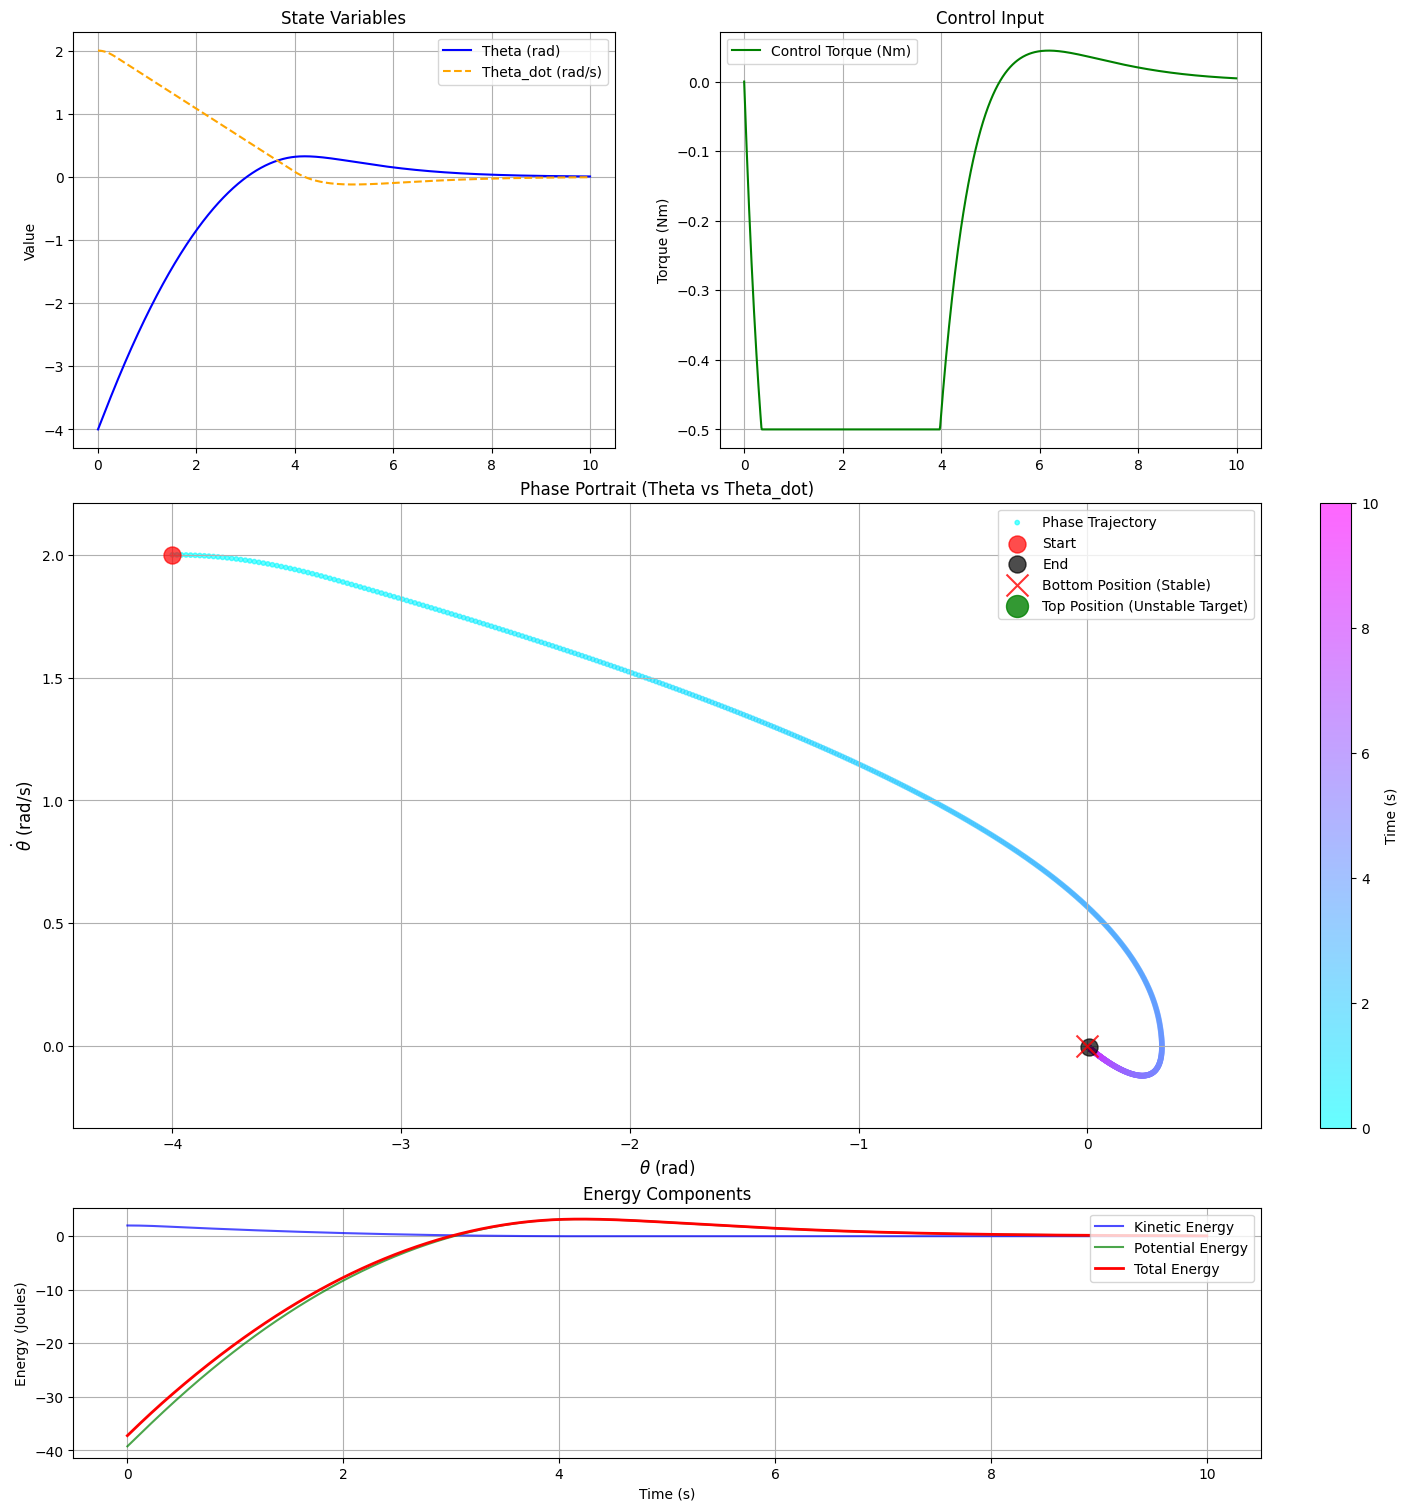

In [38]:
linear_controller = LinearFeedbackController(K1=-1, K2=-2, 
                                             target_state=np.array([0, 0]),
                                             max_control=1/2)

keeper = LightHouseKeeper(initial_position=-4,
                          initial_velocity=2,
                          control_limit=1,
                          mass=1,
                          wind_acceleration=0)

# Simulator creation
dt = 0.01  # Time step for simulation
num_steps = 1000
simulator = Simulator(system=keeper,
                      controller=linear_controller,
                      dt=dt,
                      num_steps=num_steps)


# Running the simulation
simulator.run()

# Plotting results using the simulator's method
simulator.plot_results() # Используем встроенный метод симулятора


## Implementing Bang-Bang Control (Position-Based)

Another control strategy is **Bang-Bang control**. This is a type of non-linear control where the control input switches abruptly between its maximum and minimum possible values.

**Control Law:**
In its simplest form, focusing only on position control towards the origin $x=0$, the control law applies the maximum available acceleration $A_{max}$ in the direction opposite to the current position:
$$ a = -A_{max} \cdot \text{sign}(x) $$
Where:
- $A_{max}$ is the maximum control magnitude (`control_limit`).
- $\text{sign}(x)$ is the sign function: +1 if $x>0$, -1 if $x<0$, and 0 if $x=0$.

**Operation:**
- If the keeper is to the right of the origin ($x > 0$), the controller applies full negative acceleration ($-A_{max}$).
- If the keeper is to the left of the origin ($x < 0$), the controller applies full positive acceleration ($+A_{max}$).
- If the keeper is exactly at the origin ($x = 0$), the controller applies zero acceleration.

**Characteristics:**
- **Simplicity:** This controller is very simple to implement as it only depends on the sign of the position.
- **Maximum Effort:** It always uses the maximum available control effort, which can lead to the fastest possible response in terms of initial movement towards the target.
- **No Velocity Information:** This specific version ignores the velocity $\dot{x}$. This can lead to significant overshoot and oscillations around the target, as the controller doesn't anticipate the system's momentum.
- **Chattering:** Due to the abrupt switching based only on position, the system might rapidly switch back and forth (chatter) around the setpoint ($x=0$) once it gets close, especially in the presence of delays or noise. More sophisticated Bang-Bang controllers often incorporate velocity information (a switching curve in the phase plane) to mitigate this.


In [39]:
from src.controller import Controller
from src.system import System # Import System for type hinting

class BangBangPositionController(Controller):
    """
    Implements a simple Bang-Bang controller based *only* on position sign.

    Applies a fixed maximum control effort (+max_control or -max_control)
    based on the sign of the position 'x'.
    - If x > 0, control is -max_control.
    - If x < 0, control is +max_control.
    - If x = 0, control is 0.
    The maximum control effort is defined during controller initialization.
    """
    def __init__(self, max_control: float = 1.0):
        """
        Initializes the position-based Bang-Bang controller.

        Args:
            max_control (float): The absolute value of the maximum control effort
                                 to apply. Defaults to 1.0.
        """
        if max_control <= 0:
            raise ValueError("The maximum control effort 'max_control' must be positive.")
        self.max_control = max_control # Store the max control value

    def compute_control(self, system: System, t: float | None = None) -> float:
        """
        Computes the control input based solely on the sign of the position.

        Args:
            system: The system object. Used only to get the current state [x, vx].
            t: The current time (not used by this controller).

        Returns:
            float: The computed control input (+max_control or -max_control).
        """
        # Get the current state [x, vx]
        state = system.get_state()
        x = state[0]
        v = state[1]
        # vx is not used

        # Determine the control input: -max_control * sign(x)
        # Uses the max_control value stored in the controller instance.
        if x > 0:
            control_input = -self.max_control
        elif x < 0:
            control_input = self.max_control
        else:
            control_input = 0.0

        return float(control_input) # Return a standard float

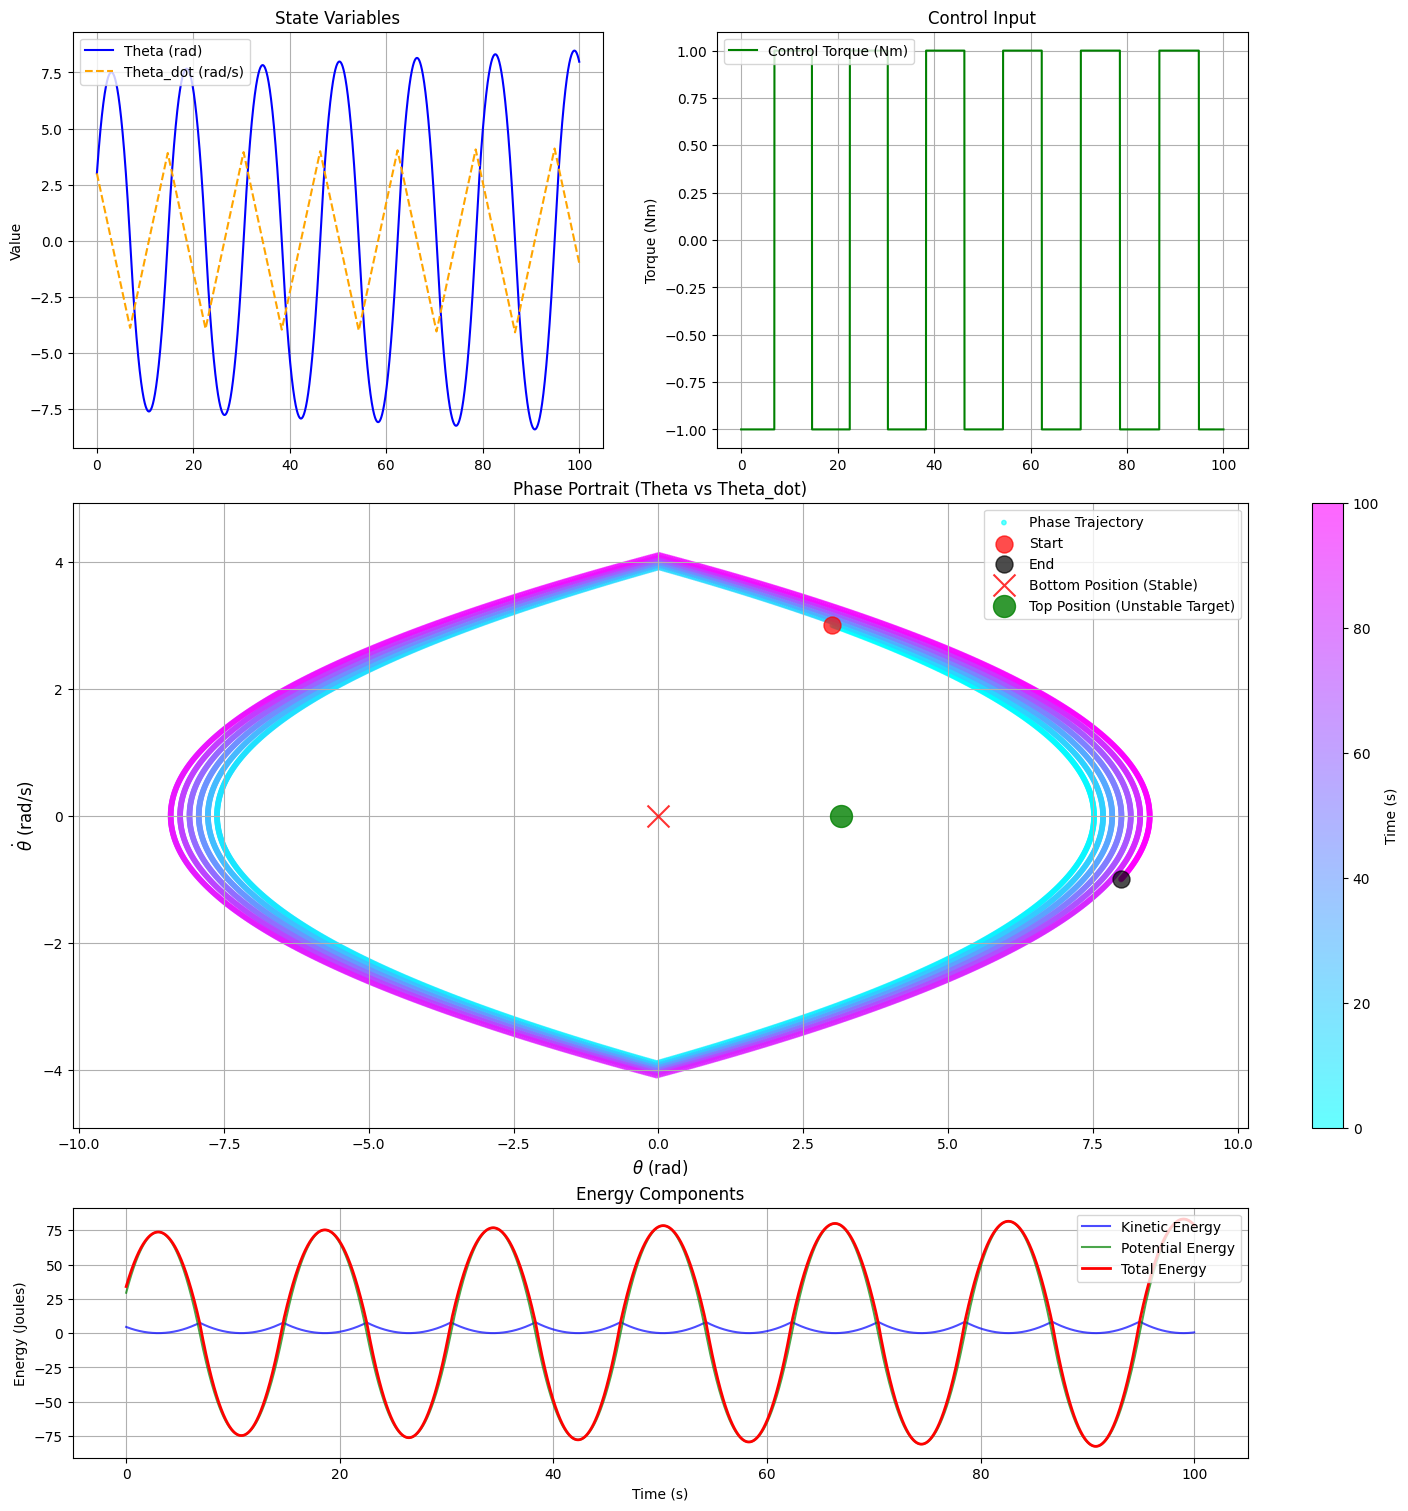

In [40]:
bang_bang_controller = BangBangPositionController(max_control=1)

keeper = LightHouseKeeper(initial_position=3,
                          initial_velocity=3,
                          mass=1,
                          wind_acceleration=0.0)

# Simulator creation
dt = 0.01  # Time step for simulation
num_steps = 10000
simulator = Simulator(system=keeper,
                      controller=bang_bang_controller,
                      dt=dt,
                      num_steps=num_steps)


# Running the simulation
simulator.run()

# Plotting results using the simulator's method
simulator.plot_results() # Используем встроенный метод симулятора

## Running Multiple Simulations with Linear Control

To assess the linear (PD) controller's overall behavior, we simulate it from many different starting positions and velocities $(x_0, \dot{x}_0)$. This helps see if it consistently brings the system to the target origin $(0,0)$.

**Process:**
We set up the `LightHouseKeeper` system and the `LinearFeedbackController` with chosen gains ($k_1, k_2$) and control limit ($A_{max}$). Then, using a simulator, we run the system dynamics for a fixed duration (`dt`, `num_steps`) starting from each initial state in a predefined list.

**Visualization: Phase Portrait**
The results are best visualized as a **phase portrait**: a plot of velocity ($\dot{x}$) versus position ($x$), showing all the simulated trajectories. Arrows indicate the flow direction.

**Expected Outcome:**
With stable gains, the phase portrait should show all trajectories converging towards an equilibrium point. If there's wind ($w \neq 0$), this point might be slightly offset from $(0,0)$ due to the constant effort needed to counteract the wind.


Running 50 simulations...


Overall Progress: 100%|██████████| 50/50 [00:00<00:00, 70.07it/s]


50 simulations finished.
Plotting 50 trajectories...


<Axes: title={'center': 'Phase Portraits - LinearFeedbackController'}, xlabel='$\\theta$', ylabel='$\\dot{\\theta}$'>

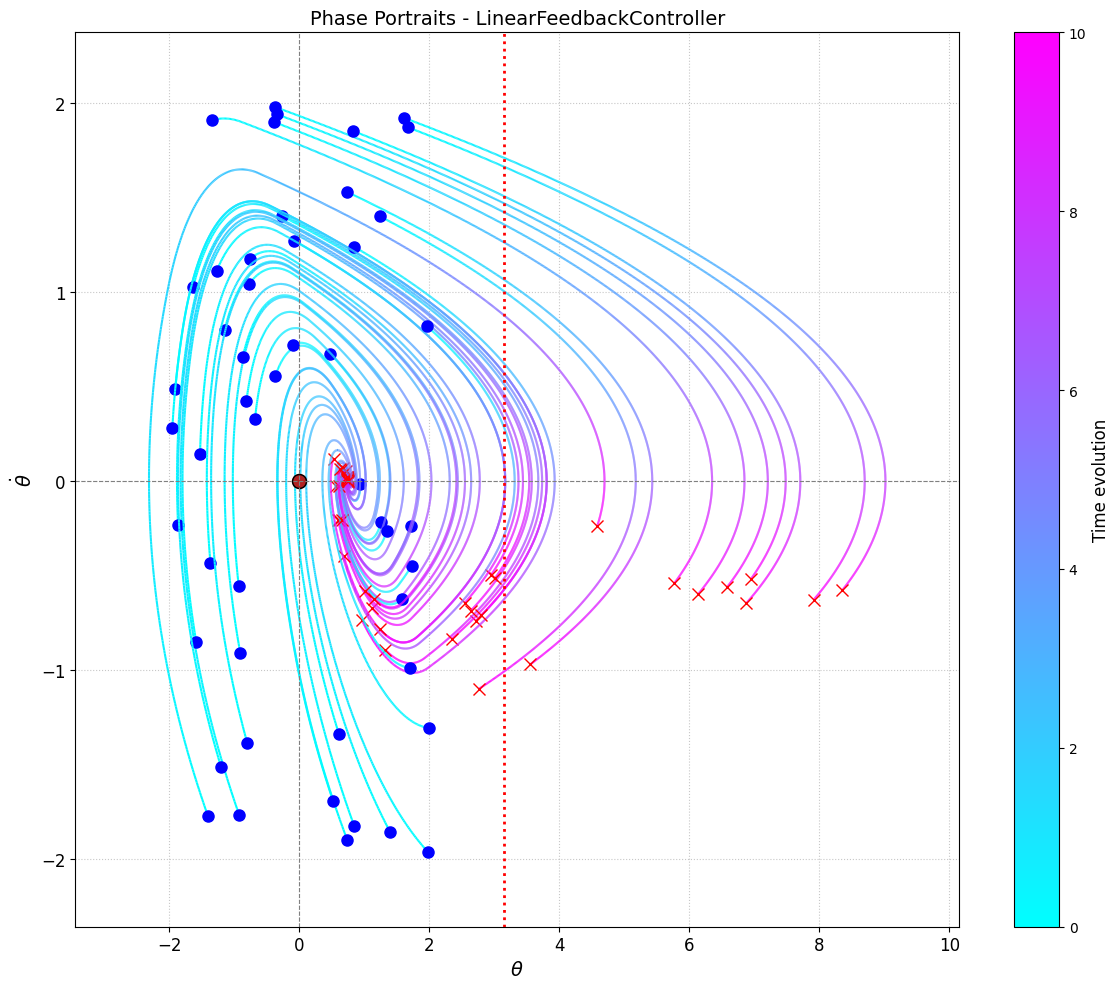

In [41]:
from src.simulator import Simulator
from src.system import System # Убедитесь, что базовые классы импортированы
from src.controller import Controller
from src.plotter import Plotter # <--- Импортируем Plotter
# Импортируйте класс системы
# from <your_system_definition_location> import LightHouseKeeper
# Импортируйте класс контроллера, который хотите использовать
# from <your_controller_definition_location> import BangBangPositionController, LinearFeedbackController, ZeroController

# --- Параметры симуляции ---
dt = 0.01
num_steps = 1000 # Количество шагов для каждой симуляции

# --- Параметры системы (LightHouseKeeper) ---
system_args = {
    'control_limit': 1.0,
    'wind_acceleration': 0.75, # Пример: без ветра для начала
    'mass': 1.0
}
# Класс системы
system_class = LightHouseKeeper

# --- Параметры контроллера ---
# Выберите контроллер и его параметры
controller_class = LinearFeedbackController
controller_args = {'K1': -1, 'K2': -1, 'max_control': 1.0, 'target_state': np.array([0, 0])}
# controller_class = BangBangPositionController
# controller_args = {'max_control': 1.0}

# --- Список начальных состояний [position, velocity] ---
n_initial_states = 50
radius = 2
initial_states_list = np.random.uniform(-radius, radius, size=(n_initial_states, 2))

# --- Запуск множественных симуляций ---
# Метод run_multiple возвращает список [(time_hist, state_hist), ...]
results = Simulator.run_multiple(
    initial_states_list=initial_states_list,
    system_class=system_class,
    system_args=system_args,
    controller_class=controller_class,
    controller_args=controller_args,
    dt=dt,
    num_steps=num_steps
)

# --- Построение фазовых траекторий с помощью Plotter ---
# Создаем экземпляр Plotter (можно передать None, т.к. данные будут переданы в метод)
plotter_instance = Plotter(None, None, None, None)

# Вызываем метод для построения множественных портретов
plotter_instance.plot_multiple_phase_portraits(
    simulation_results_list=results,
    title=f"Phase Portraits - {controller_class.__name__}",
    equilibrium_point=np.array([0.0, 0.0]) # Точка равновесия (0,0) для LightHouseKeeper
    # plot_range=(-3, 3, -2, 2) # Опционально: задать пределы осей
)

# Отображение графика (plotter_instance.plot_multiple_phase_portraits должен сам вызвать plt.show())
# plt.show() # Обычно не требуется, если метод плоттера уже это делает

# Adaptive Control for a System with Wind Disturbance

## 1. Problem Statement with Wind Disturbance

Consider a system described by the differential equation:

$$\ddot{x} = a + d(t)$$

where:
- $\ddot{x}$ - second derivative of $x$ with respect to time
- $a$ - control parameter
- $d(t)$ - external disturbance caused by wind (assumed unknown)

The objective is to design an adaptive control law that ensures the global stability of the system in the presence of the disturbance $d(t)$.

## 2. Transformation to State-Space Form

As before, let's introduce state variables:

$$x_1 = x$$
$$x_2 = \dot{x}$$

Then the system takes the form:

$$\dot{x}_1 = x_2$$
$$\dot{x}_2 = a + d(t)$$

## 3. Idea of Adaptive Control

Since the disturbance $d(t)$ is unknown, we will use its estimate $\hat{d}(t)$, which will be adaptively adjusted in real-time. Let's define the disturbance estimation error:

$$\tilde{d}(t) = d(t) - \hat{d}(t)$$

## 4. Choice of Control Law

The following control law is proposed:

$$a = -x_1 - kx_2 - \hat{d}(t)$$

where:
- $-x_1 - kx_2$ - the baseline control, as in the previous case without disturbance
- $-\hat{d}(t)$ - the compensating component, based on the disturbance estimate

## 5. Augmented Lyapunov Function

For stability analysis and synthesis of the adaptation law, let's augment the Lyapunov function:

$$V(x_1, x_2, \tilde{d}) = \frac{1}{2}x_1^2 + \frac{1}{2}x_2^2 + \frac{1}{2\gamma}\tilde{d}^2$$

where $\gamma > 0$ is the adaptation rate parameter.

## 6. Derivative of the Augmented Lyapunov Function

Let's find the derivative of the Lyapunov function along the system trajectories:

$$\dot{V} = x_1\dot{x}_1 + x_2\dot{x}_2 + \frac{1}{\gamma}\tilde{d}\dot{\tilde{d}}$$

Substituting the system equations:

$$\dot{V} = x_1 x_2 + x_2(a + d(t)) + \frac{1}{\gamma}\tilde{d}\dot{\tilde{d}}$$

Substituting the control law $a = -x_1 - kx_2 - \hat{d}(t)$:

$$\dot{V} = x_1 x_2 + x_2(-x_1 - kx_2 - \hat{d}(t) + d(t)) + \frac{1}{\gamma}\tilde{d}\dot{\tilde{d}}$$

Rearranging:

$$\dot{V} = x_1 x_2 - x_1 x_2 - kx_2^2 + x_2(d(t) - \hat{d}(t)) + \frac{1}{\gamma}\tilde{d}\dot{\tilde{d}}$$

$$\dot{V} = -kx_2^2 + x_2\tilde{d} + \frac{1}{\gamma}\tilde{d}\dot{\tilde{d}}$$

## 7. Synthesis of the Adaptation Law

Considering that $\dot{\tilde{d}} = \dot{d} - \dot{\hat{d}}$, let's choose the adaptation law for the disturbance estimate:

$$\dot{\hat{d}} = \gamma x_2$$

Substituting this law into the expression for the Lyapunov function derivative:

$$\dot{V} = -kx_2^2 + x_2\tilde{d} + \frac{1}{\gamma}\tilde{d}(\dot{d} - \gamma x_2)$$

$$\dot{V} = -kx_2^2 + x_2\tilde{d} + \frac{1}{\gamma}\tilde{d}\dot{d} - \tilde{d}x_2$$

$$\dot{V} = -kx_2^2 + \frac{1}{\gamma}\tilde{d}\dot{d}$$

## 8. Stability Analysis

### 8.1. Case of Constant Disturbance

If the disturbance is constant, i.e., $\dot{d}(t) = 0$, then:

$$\dot{V} = -kx_2^2 \leq 0$$

Applying LaSalle's invariance principle, it can be shown that the system is asymptotically stable.

### 8.2. Case of Time-Varying Disturbance

If the disturbance varies with time ($\dot{d}(t) \neq 0$), but its derivative is bounded, i.e., $|\dot{d}(t)| \leq \delta$ for some $\delta > 0$, then:

$$\dot{V} \leq -kx_2^2 + \frac{\delta}{\gamma}|\tilde{d}|$$

In this case, the system will be ultimately bounded, and the size of the region of attraction will depend on the magnitude of $\delta$ and the parameter $\gamma$.

## 9. Generalized Adaptive Control

For more complex forms of disturbance, the approach can be extended by representing the disturbance as a linear combination of known functions with unknown coefficients:

$$d(t) = \sum_{i=1}^{n} \theta_i \phi_i(x_1, x_2, t)$$

where $\theta_i$ are unknown parameters, and $\phi_i$ are known functions. The estimation of the parameters $\theta_i$ is performed using a corresponding adaptive law.

## 10. Practical Implementation

The complete adaptive control algorithm includes:

1.  **Control Law**: $a = -x_1 - kx_2 - \hat{d}(t)$
2.  **Adaptation Law**: $\dot{\hat{d}} = \gamma x_2$

Initial conditions: $\hat{d}(0) = 0$ (or another initial estimate)

The parameter $\gamma$ is chosen as a trade-off between the speed of adaptation and sensitivity to noise: large values of $\gamma$ provide fast adaptation but increase sensitivity to measurement noise.

## 11. Conclusion

The developed adaptive control ensures:
1. Asymptotic stability for constant wind disturbance
2. Ultimate boundedness for time-varying disturbance with a bounded derivative

The main advantage of this approach is that it does not require prior knowledge of the disturbance magnitude but adaptively adjusts to it during system operation.


In [42]:
import os
import datetime

class AdaptiveLinearController(Controller):
    """
    Adaptive linear controller with disturbance estimation for a 2nd order system.

    Accumulates the disturbance estimate (d_hat) history in memory and saves
    it to a unique file (named using a provided controller_id) in the
    'adaptation_log' directory when save_log() is called.
    Each call to save_log() overwrites the file for that controller_id.

    Implements the control law: a = -x1 - k*x2 - d_hat
    The adaptation law (d_hat_dot = alpha * x2) is updated internally
    within the compute_control method using the state *before* the step.
    If alpha = 0, adaptation is disabled and d_hat remains constant.

    Assumes the system state is [x1, x2] = [position, velocity].
    The disturbance estimate 'd_hat' compensates for an unknown constant
    or slowly varying disturbance acting on the x2 dynamics (acceleration).
    """
    def __init__(self, controller_id: str,
                 k: float,
                 alpha: float = 1/100,
                 dt: float = 1/100,
                 initial_d_hat: float = 0.0,
                 max_control: float = 1.0,
                 log_dir: str = "adaptation_log"):
        """
        Initializes the adaptive controller.

        Args:
            controller_id (str): A unique identifier provided by the user for this controller instance/experiment.
                                Used for naming the log file.
            k (float): Gain for the velocity feedback term (-k*x2). Must be positive.
            alpha (float): Adaptation gain for the disturbance estimate update. Must be non-negative (alpha >= 0).
            dt (float): Simulation time step. Required for internal adaptation update.
            initial_d_hat (float): Initial guess for the disturbance estimate d_hat(0). Defaults to 0.0.
            max_control (float): Absolute limit for the control input.
            log_dir (str): Directory where adaptation log files will be stored. Defaults to "adaptation_log".
        """
        if not controller_id or not isinstance(controller_id, str):
             raise ValueError("controller_id must be a non-empty string.")
        if k <= 0:
            raise ValueError("Feedback gain 'k' must be positive.")
        if alpha < 0:
            raise ValueError("Adaptation gain 'alpha' must be non-negative.")
        if dt <= 0:
             raise ValueError("Time step 'dt' must be positive.")

        self.controller_id = controller_id
        self.k = k
        self.alpha = alpha
        self.dt = dt
        self.d_hat = float(initial_d_hat)
        self.max_control = abs(max_control)
        self.log_dir = log_dir
        sanitized_id = controller_id.replace(" ", "_").replace("/", "-").replace("\\", "-").replace(":", "-")
        self.log_filepath = os.path.join(self.log_dir, f"adapt_log_{sanitized_id}.txt")

        self.reset_history() # For in-memory history

    def _setup_logging(self) -> str | None:
        """Creates log directory, generates filename, and writes header."""
        try:
            os.makedirs(self.log_dir, exist_ok=True)
        except OSError as e:
            print(f"Warning: Could not create log directory {self.log_dir}: {e}")
            return None # Indicate logging is disabled

        log_filepath = os.path.join(self.log_dir, f"adapt_log_{self.controller_id}.txt")
        try:
            with open(log_filepath, 'w') as f: # Use 'w' to overwrite if exists
                f.write(f"# Log started for AdaptiveLinearController\n")
                f.write(f"# Controller ID: {self.controller_id}\n")
                f.write(f"# Timestamp: {datetime.datetime.now().isoformat()}\n")
                f.write(f"# Parameters: k={self.k}, alpha={self.alpha}, dt={self.dt}, initial_d_hat={self.d_hat}, max_control={self.max_control}\n") # Access params via self
                f.write("# --- Data --- \n")
                f.write("d_hat\n") # Simple header for the data column
            return log_filepath
        except IOError as e:
            print(f"Warning: Could not write log header to {log_filepath}: {e}")
            return None # Disable logging if header fails

    def _log_adaptation_parameter(self):
        """Appends the current d_hat value to the log file."""
        if self.log_filepath: # Only log if filepath was successfully set up
            try:
                with open(self.log_filepath, 'a') as f:
                    f.write(f"{self.d_hat:.8f}\n")
            except IOError as e:
                print(f"Warning: Could not write to log file {self.log_filepath}: {e}")
                # Optional: Disable further logging attempts for this instance?
                # self.log_filepath = None

    def compute_control(self, system: System, t: float | None = None) -> float:
        """
        Updates the disturbance estimate (if alpha > 0) and computes the control input 'a'.
        Logging to file is NOT done here anymore.

        Args:
            system: The system object, used to get the current state [x1, x2].
            t: Current time (not explicitly used in this control law).

        Returns:
            float: The calculated control input 'a', clipped by max_control.
        """
        state = system.get_state()
        x1 = state[0] # Position
        x2 = state[1] # Velocity

        # --- Internal Adaptation Update --- 
        # Only update if alpha is non-zero, otherwise d_hat remains constant
        if self.alpha > 0:
            d_hat_dot = self.alpha * x2
            self.d_hat += d_hat_dot * self.dt
        # Always append the current (potentially unchanged) d_hat to history
        self.d_hat_history.append(self.d_hat)
        # --------------------------------


        control_input = -(x1 + self.k * x2 + self.d_hat) #edit

        # Clip the control input
        control_input = np.clip(control_input, -self.max_control, self.max_control)

        return float(control_input)

    def save_log(self):
        """
        Saves the accumulated adaptation history (d_hat_history) to the log file
        associated with this controller's ID. Overwrites the file if it exists.
        Should be called after the simulation run is complete.
        """
        print(f"Saving adaptation log for ID '{self.controller_id}' to: {self.log_filepath}")
        try:
            os.makedirs(self.log_dir, exist_ok=True)
        except OSError as e:
            print(f"Error: Could not create log directory {self.log_dir}: {e}. Log not saved.")
            return

        try:
            with open(self.log_filepath, 'w') as f: # Always overwrite
                # Write Header
                f.write(f"# Log saved for AdaptiveLinearController\n")
                f.write(f"# Controller ID: {self.controller_id}\n")
                f.write(f"# Timestamp: {datetime.datetime.now().isoformat()}\n")
                initial_recorded_d_hat = self.d_hat_history[0] if self.d_hat_history else self.d_hat
                f.write(f"# Parameters: k={self.k}, alpha={self.alpha}, dt={self.dt}, initial_d_hat={initial_recorded_d_hat}, max_control={self.max_control}\n")
                f.write("# --- Data --- \n")
                f.write("d_hat\n")

                # Write Data
                for estimate in self.d_hat_history:
                    f.write(f"{estimate:.8f}\n")
            print("Log saved successfully.")
        except IOError as e:
            print(f"Error: Could not write log file {self.log_filepath}: {e}")
        except IndexError:
             print(f"Warning: Log saved for {self.log_filepath}, but estimation history was empty.")

    def get_disturbance_estimate(self) -> float:
        """Returns the current disturbance estimate."""
        return self.d_hat

    def get_estimate_history(self) -> list[float]:
        """Returns the history of the disturbance estimate stored in memory."""
        # Return a copy to prevent external modification
        return list(self.d_hat_history)

    def reset_history(self):
        """Resets the in-memory estimation history."""
        # History now starts empty, first estimate added during first compute_control call
        self.d_hat_history = [] 

Running simulation with AdaptiveLinearController...


Simulation finished.
Saving adaptation log for ID '1' to: adaptation_log/adapt_log_1.txt
Log saved successfully.


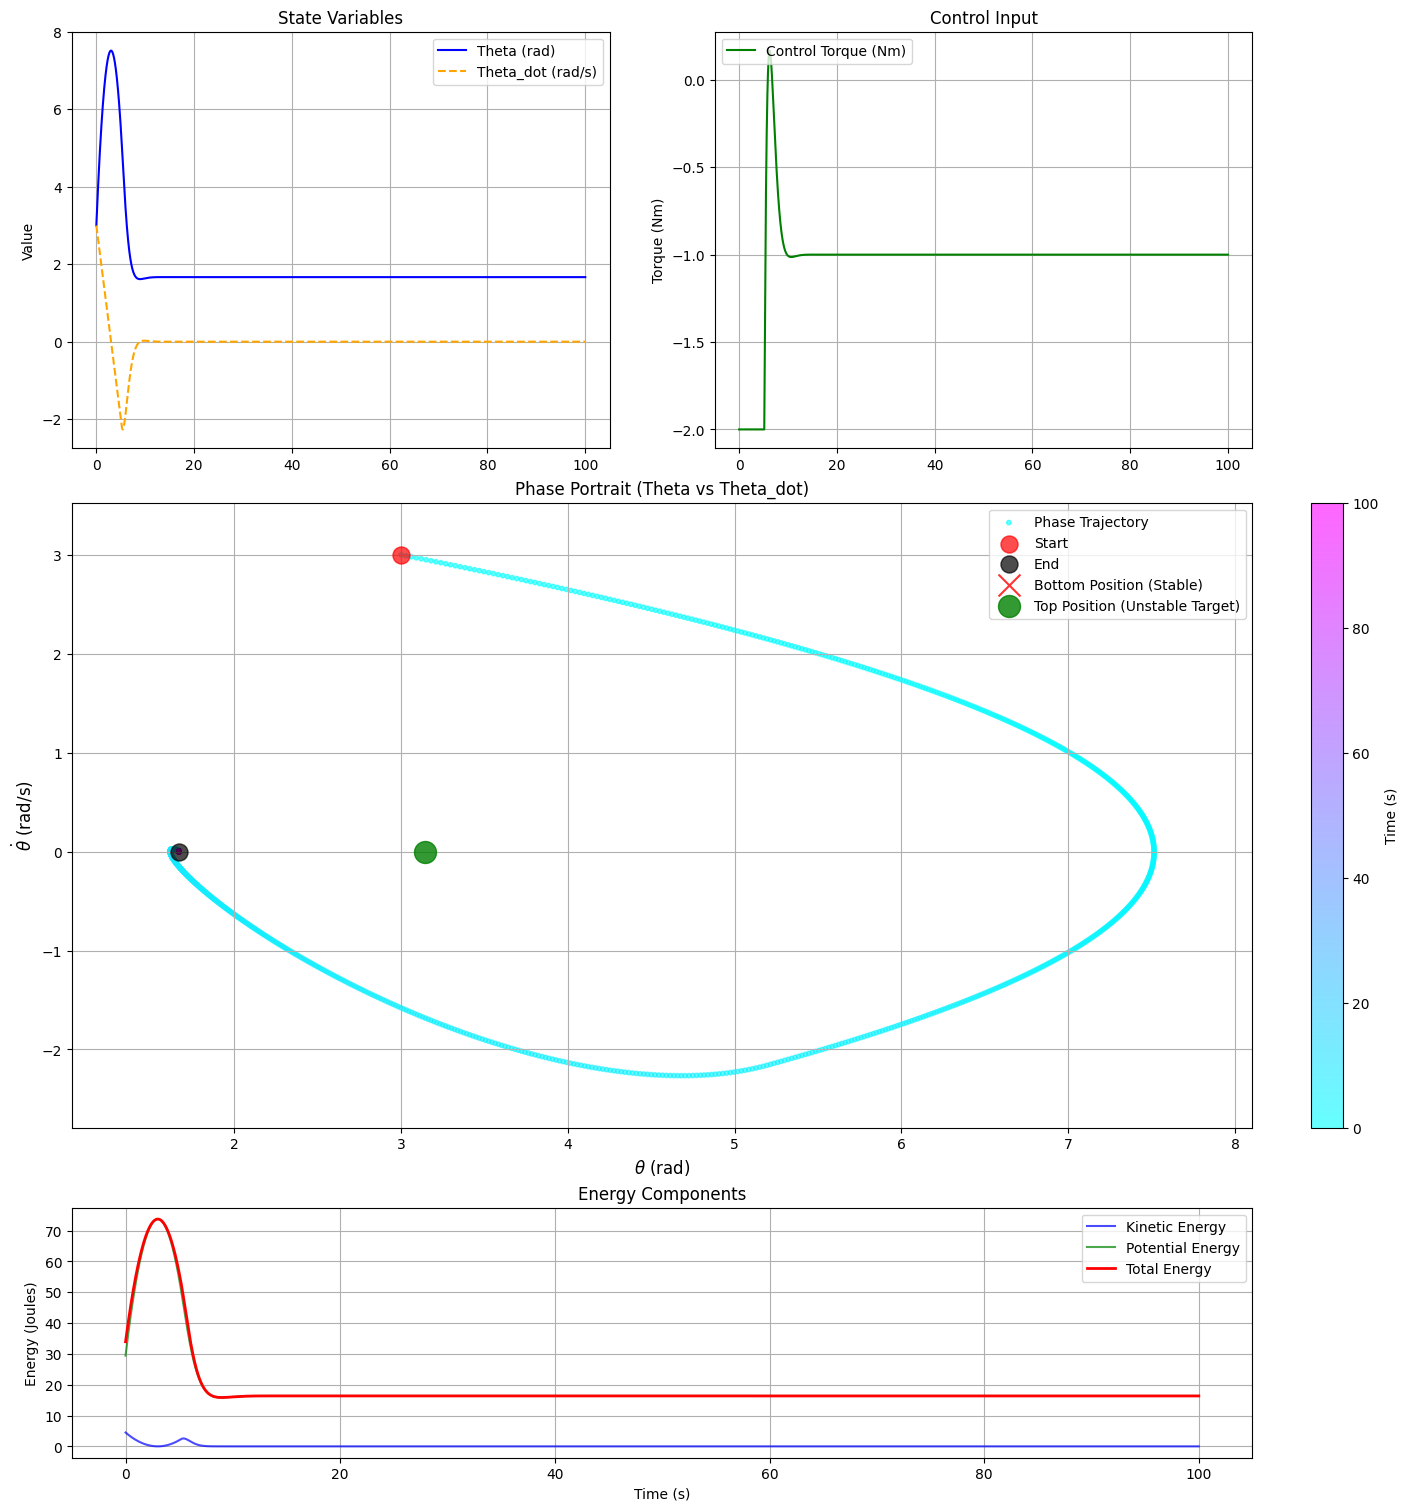

Plotting disturbance estimation...


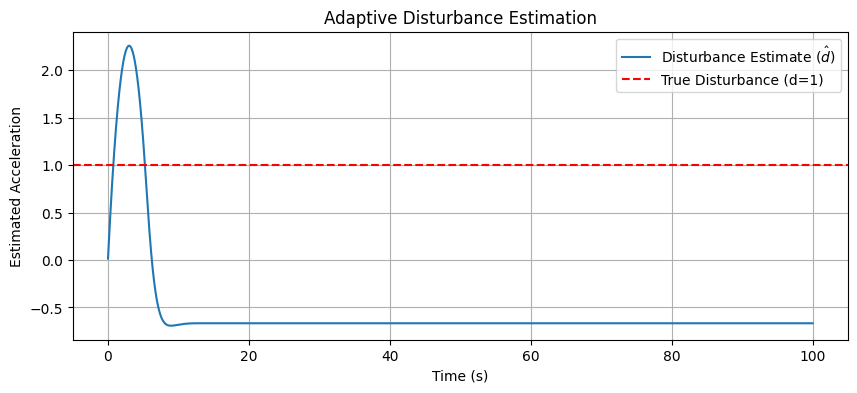

In [47]:
dt = 0.01          # Time step (as in the example)
num_steps = 10000  # Number of steps (as in the example)

# --- System Parameters (LightHouseKeeper) ---
# Using values from your example, but adding wind disturbance
initial_position = 3.0
initial_velocity = 3.0
true_wind_acceleration = 1 # <<< Adding wind disturbance for adaptation test
control_limit_system = 2.0   # Example system limit (may differ from controller limit)
mass = 1.0

keeper = LightHouseKeeper(initial_position=initial_position,
                          initial_velocity=initial_velocity,
                          control_limit=control_limit_system,
                          mass=mass,
                          wind_acceleration=true_wind_acceleration) # <<< Passing the disturbance

# --- Adaptive Controller Parameters ---
k_gain = 2       # Coefficient for velocity term (-k*x2)
alpha_adapt = .5  # Adaptation coefficient
initial_d_hat_guess = 0.0 # Initial disturbance estimate
max_control_controller = 2.0 # Maximum control action of the controller

# Create Adaptive Controller (instead of BangBang)
# Pass dt to the controller
adaptive_controller = AdaptiveLinearController(k=k_gain,
                                             alpha=alpha_adapt,
                                             dt=dt, # <<< Pass dt
                                             initial_d_hat=initial_d_hat_guess,
                                             max_control=max_control_controller,
                                             controller_id="1")

# --- Simulator Creation ---
# Pass the new controller
simulator = Simulator(system=keeper,
                      controller=adaptive_controller, # <<< Using adaptive_controller
                      dt=dt,
                      num_steps=num_steps)

# --- Running Simulation ---
print("Running simulation with AdaptiveLinearController...")
simulator.run()
print("Simulation finished.")
adaptive_controller.save_log()

    # Attempt to use the built-in method, as in your example
simulator.plot_results()

print("Plotting disturbance estimation...")
estimate_history = adaptive_controller.get_estimate_history()
time_for_estimate = simulator.time_vector[1:len(estimate_history)+1]

plt.figure(figsize=(10, 4))
plt.plot(time_for_estimate, estimate_history, label='Disturbance Estimate ($\hat{d}$)')
plt.axhline(true_wind_acceleration, color='r', linestyle='--', label=f'True Disturbance (d={true_wind_acceleration})')
plt.title('Adaptive Disturbance Estimation')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Acceleration')
plt.legend()
plt.grid(True)
plt.show()

Running 50 simulations...


Overall Progress: 100%|██████████| 50/50 [00:02<00:00, 18.53it/s]


50 simulations finished.
Plotting 50 trajectories...

Multiple simulations finished and plotted using Plotter.
NOTE: The axis labels on the plot (theta/theta_dot) might be incorrect for the LightHouseKeeper system.


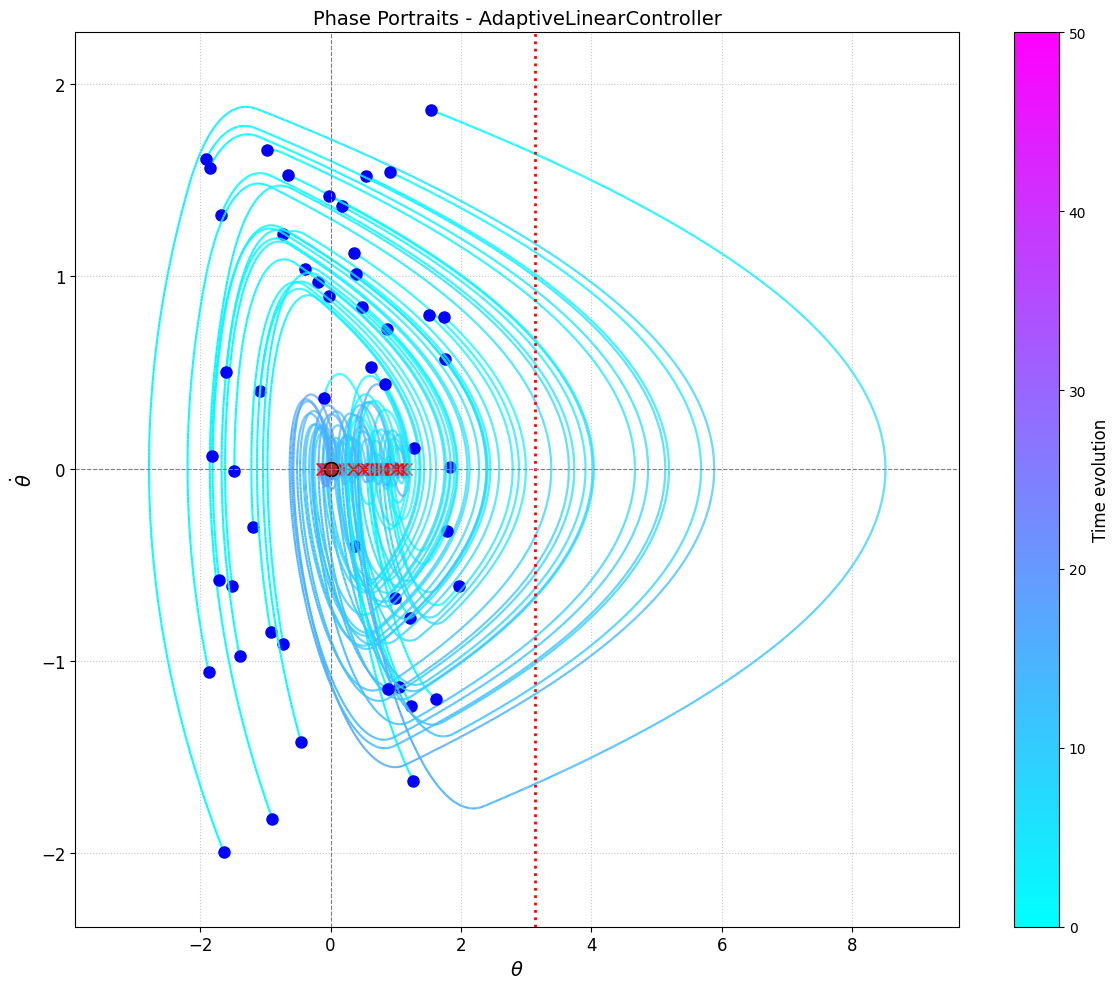

In [44]:
from src.simulator import Simulator
from src.system import System # Ensure base classes are imported
from src.controller import Controller
from src.plotter import Plotter # <--- Import Plotter
# Import the system class
# from <your_system_definition_location> import LightHouseKeeper
# Import the controller class you want to use
# from <your_controller_definition_location> import BangBangPositionController, LinearFeedbackController, ZeroController

# --- Simulation parameters ---
dt = 0.01
num_steps = 5000 # Number of steps for each simulation

# --- System parameters (LightHouseKeeper) ---
system_args = {
    'control_limit': 1.0,
    'wind_acceleration': 0.75, # Example: no wind initially
    'mass': 1.0
}
# System class
system_class = LightHouseKeeper

# --- Controller parameters ---
# Select the controller and its parameters
controller_class = AdaptiveLinearController
controller_args = {'k': 1, 'max_control': 1.0, 'alpha': 0.5, 'controller_id':'1'}
# controller_class = BangBangPositionController
# controller_args = {'max_control': 1.0}

# --- List of initial states [position, velocity] ---
n_initial_states = 50
radius = 2
initial_states_list = np.random.uniform(-radius, radius, size=(n_initial_states, 2))

# --- Running multiple simulations ---
# The run_multiple method returns a list [(time_hist, state_hist), ...]
results = Simulator.run_multiple(
    initial_states_list=initial_states_list,
    system_class=system_class,
    system_args=system_args,
    controller_class=controller_class,
    controller_args=controller_args,
    dt=dt,
    num_steps=num_steps
)

# --- Building phase portraits using Plotter ---
# Create an instance of Plotter
plotter_instance = Plotter(None, None, None, None)

# Call the method to plot multiple phase portraits
plotter_instance.plot_multiple_phase_portraits(
    simulation_results_list=results,
    title=f"Phase Portraits - {controller_class.__name__}",
    equilibrium_point=np.array([0.0, 0.0]) # Target equilibrium point for LightHouseKeeper
    # plot_range=(-3, 3, -2, 2) # Optional: set axis limits
)

# Display plot (plotter_instance.plot_multiple_phase_portraits should call plt.show() itself)
# plt.show() # Usually not required if the plotter method already does this

print("\nMultiple simulations finished and plotted using Plotter.")
print("NOTE: The axis labels on the plot (theta/theta_dot) might be incorrect for the LightHouseKeeper system.")
# Reminder: log file 'adapt_log_multi_sim_beta_plotter.txt' will contain
# only the d_hat estimation history from the *last* simulation of the set.

As can be seen from the simulation results (or as shown in the phase portrait graph), using the adaptation law $\dot{\hat{d}} = \gamma x_2$, based only on velocity, leads to the stabilization of the system, but the equilibrium point is shifted from the origin. This means that although the velocity error and control tend to zero, the position error ($x_1$) does not necessarily converge to zero due to the constant disturbance $d$.

To eliminate this residual offset and ensure the convergence of both position ($x_1$) and velocity ($x_2$) to zero, the adaptation law can be modified by adding a term proportional to the position error. The new adaptation law takes the form: $\dot{\hat{d}} = \gamma x_2 + \beta x_1$, where $\beta$ is a new adaptation coefficient.


In [45]:
class AdaptiveLinearController2(Controller):
    """
    Adaptive linear controller with disturbance estimation for a 2nd order system,
    including an adaptation term based on position (x1).

    Accumulates the disturbance estimate (d_hat) history in memory and saves
    it to a unique file (named using a provided controller_id) in the
    'adaptation_log' directory when save_log() is called.
    Each call to save_log() overwrites the file for that controller_id.

    Implements the control law: a = -x1 - k*x2 - d_hat
    The adaptation law (d_hat_dot = alpha * x2 + beta * x1) is updated internally
    within the compute_control method using the state *before* the step.
    If alpha = 0 and beta = 0, adaptation is disabled and d_hat remains constant.

    Assumes the system state is [x1, x2] = [position, velocity].
    The disturbance estimate 'd_hat' compensates for an unknown constant
    or slowly varying disturbance acting on the x2 dynamics (acceleration).
    """
    def __init__(self, controller_id: str,
                 k: float,
                 alpha: float = 1/100,
                 beta: float = 0.1, # Added beta parameter
                 dt: float = 1/100,
                 initial_d_hat: float = 0.0,
                 max_control: float = 1.0,
                 log_dir: str = "adaptation_log"):
        """
        Initializes the adaptive controller.

        Args:
            controller_id (str): A unique identifier provided by the user for this controller instance/experiment.
                                Used for naming the log file.
            k (float): Gain for the velocity feedback term (-k*x2). Must be positive.
            alpha (float): Adaptation gain for the velocity term (x2). Must be non-negative (alpha >= 0).
            beta (float): Adaptation gain for the position term (x1). Defaults to 0.1.
            dt (float): Simulation time step. Required for internal adaptation update.
            initial_d_hat (float): Initial guess for the disturbance estimate d_hat(0). Defaults to 0.0.
            max_control (float): Absolute limit for the control input.
            log_dir (str): Directory where adaptation log files will be stored. Defaults to "adaptation_log".
        """
        if not controller_id or not isinstance(controller_id, str):
             raise ValueError("controller_id must be a non-empty string.")
        if k <= 0:
            raise ValueError("Feedback gain 'k' must be positive.")
        if alpha < 0:
            raise ValueError("Adaptation gain 'alpha' must be non-negative.")
        # beta can be positive, negative or zero
        if dt <= 0:
             raise ValueError("Time step 'dt' must be positive.")

        self.controller_id = controller_id
        self.k = k
        self.alpha = alpha
        self.beta = beta # Store beta
        self.dt = dt
        self.d_hat = float(initial_d_hat)
        self.max_control = abs(max_control)
        self.log_dir = log_dir
        sanitized_id = controller_id.replace(" ", "_").replace("/", "-").replace("\\", "-").replace(":", "-")
        self.log_filepath = os.path.join(self.log_dir, f"adapt_log_{sanitized_id}.txt")

        self.reset_history() # For in-memory history

    def _setup_logging(self) -> str | None:
        """Creates log directory, generates filename, and writes header."""
        try:
            os.makedirs(self.log_dir, exist_ok=True)
        except OSError as e:
            print(f"Warning: Could not create log directory {self.log_dir}: {e}")
            return None # Indicate logging is disabled

        log_filepath = os.path.join(self.log_dir, f"adapt_log_{self.controller_id}.txt")
        try:
            with open(log_filepath, 'w') as f: # Use 'w' to overwrite if exists
                f.write(f"# Log started for AdaptiveLinearController\n")
                f.write(f"# Controller ID: {self.controller_id}\n")
                f.write(f"# Timestamp: {datetime.datetime.now().isoformat()}\n")
                f.write(f"# Parameters: k={self.k}, alpha={self.alpha}, beta={self.beta}, dt={self.dt}, initial_d_hat={self.d_hat}, max_control={self.max_control}\n") # Access params via self
                f.write("# --- Data --- \n")
                f.write("d_hat\n") # Simple header for the data column
            return log_filepath
        except IOError as e:
            print(f"Warning: Could not write log header to {log_filepath}: {e}")
            return None # Disable logging if header fails

    def _log_adaptation_parameter(self):
        """Appends the current d_hat value to the log file."""
        if self.log_filepath: # Only log if filepath was successfully set up
            try:
                with open(self.log_filepath, 'a') as f:
                    f.write(f"{self.d_hat:.8f}\n")
            except IOError as e:
                print(f"Warning: Could not write to log file {self.log_filepath}: {e}")
                # Optional: Disable further logging attempts for this instance?
                # self.log_filepath = None

    def compute_control(self, system: System, t: float | None = None) -> float:
        """
        Updates the disturbance estimate (if alpha > 0 or beta != 0) and computes the control input 'a'.
        Logging to file is NOT done here anymore.

        Args:
            system: The system object, used to get the current state [x1, x2].
            t: Current time (not explicitly used in this control law).

        Returns:
            float: The calculated control input 'a', clipped by max_control.
        """
        state = system.get_state()
        x1 = state[0] # Position
        x2 = state[1] # Velocity

        # --- Internal Adaptation Update --- 
        # Update if either adaptation gain is non-zero
        if self.alpha != 0 or self.beta != 0:
            d_hat_dot = self.alpha * x2 + self.beta * x1 # Use alpha and beta
            self.d_hat += d_hat_dot * self.dt
        # Always append the current (potentially unchanged) d_hat to history
        self.d_hat_history.append(self.d_hat)
        # --------------------------------


        control_input = ...

        # Clip the control input
        control_input = np.clip(control_input, -self.max_control, self.max_control)

        return float(control_input)

    def save_log(self):
        """
        Saves the accumulated adaptation history (d_hat_history) to the log file
        associated with this controller's ID. Overwrites the file if it exists.
        Should be called after the simulation run is complete.
        """
        print(f"Saving adaptation log for ID '{self.controller_id}' to: {self.log_filepath}")
        try:
            os.makedirs(self.log_dir, exist_ok=True)
        except OSError as e:
            print(f"Error: Could not create log directory {self.log_dir}: {e}. Log not saved.")
            return

        try:
            with open(self.log_filepath, 'w') as f: # Always overwrite
                # Write Header
                f.write(f"# Log saved for AdaptiveLinearControllerWithBeta\n") # Updated class name
                f.write(f"# Controller ID: {self.controller_id}\n")
                f.write(f"# Timestamp: {datetime.datetime.now().isoformat()}\n")
                initial_recorded_d_hat = self.d_hat_history[0] if self.d_hat_history else self.d_hat
                # Include beta in parameters
                f.write(f"# Parameters: k={self.k}, alpha={self.alpha}, beta={self.beta}, dt={self.dt}, initial_d_hat={initial_recorded_d_hat}, max_control={self.max_control}\n")
                f.write("# --- Data --- \n")
                f.write("d_hat\n")

                # Write Data
                for estimate in self.d_hat_history:
                    f.write(f"{estimate:.8f}\n")
            print("Log saved successfully.")
        except IOError as e:
            print(f"Error: Could not write log file {self.log_filepath}: {e}")
        except IndexError:
             print(f"Warning: Log saved for {self.log_filepath}, but estimation history was empty.")

    def get_disturbance_estimate(self) -> float:
        """Returns the current disturbance estimate."""
        return self.d_hat

    def get_estimate_history(self) -> list[float]:
        """Returns the history of the disturbance estimate stored in memory."""
        # Return a copy to prevent external modification
        return list(self.d_hat_history)

    def reset_history(self):
        """Resets the in-memory estimation history."""
        # History now starts empty, first estimate added during first compute_control call
        self.d_hat_history = [] 

In [46]:
dt = 0.01          # Time step (as in the example)
num_steps = 10000  # Number of steps (as in the example)

# --- System Parameters (LightHouseKeeper) ---
# Using values from your example, but adding wind disturbance
initial_position = 3.0
initial_velocity = 3.0
true_wind_acceleration = 1 # <<< Adding wind disturbance for adaptation test
control_limit_system = 2.0   # Example system limit (may differ from controller limit)
mass = 1.0

keeper = LightHouseKeeper(initial_position=initial_position,
                          initial_velocity=initial_velocity,
                          control_limit=control_limit_system,
                          mass=mass,
                          wind_acceleration=true_wind_acceleration) # <<< Passing the disturbance

# --- Adaptive Controller Parameters ---
k_gain = 5      # Coefficient for velocity term (-k*x2)
alpha_adapt = .1  # Adaptation coefficient
beta_adapt = 0.1
initial_d_hat_guess = 0.0 # Initial disturbance estimate
max_control_controller = 1.5 # Maximum control action of the controller

# Create Adaptive Controller (instead of BangBang)
# Pass dt to the controller
adaptive_controller = AdaptiveLinearController2(k=k_gain,
                                             alpha=alpha_adapt,
                                             beta=beta_adapt,
                                             dt=dt, # <<< Pass dt
                                             initial_d_hat=initial_d_hat_guess,
                                             max_control=max_control_controller,
                                             controller_id="1")

# --- Simulator Creation ---
# Pass the new controller
simulator = Simulator(system=keeper,
                      controller=adaptive_controller, # <<< Using adaptive_controller
                      dt=dt,
                      num_steps=num_steps)

# --- Running Simulation ---
print("Running simulation with AdaptiveLinearController...")
simulator.run()
print("Simulation finished.")
adaptive_controller.save_log()

    # Attempt to use the built-in method, as in your example
simulator.plot_results()

print("Plotting disturbance estimation...")
estimate_history = adaptive_controller.get_estimate_history()
time_for_estimate = simulator.time_vector[1:len(estimate_history)+1]

plt.figure(figsize=(10, 4))
plt.plot(time_for_estimate, estimate_history, label='Disturbance Estimate ($\hat{d}$)')
plt.axhline(true_wind_acceleration, color='r', linestyle='--', label=f'True Disturbance (d={true_wind_acceleration})')
plt.title('Adaptive Disturbance Estimation')
plt.xlabel('Time (s)')
plt.ylabel('Estimated Acceleration')
plt.legend()
plt.grid(True)
plt.show()

Running simulation with AdaptiveLinearController...


TypeError: '>=' not supported between instances of 'ellipsis' and 'float'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Import your classes
from src.simulator import Simulator
from src.plotter import Plotter # <<< Import Plotter
# Ensure LightHouseKeeper and AdaptiveLinearControllerWithBeta are available
# (defined above or imported correctly)
# from <...> import LightHouseKeeper
from adaptive_linear_2 import AdaptiveLinearController # <<< Import the correct controller

# --- Function to generate random points (if needed) ---
def generate_random_points_in_circle(N: int, r: float) -> list[np.ndarray]:
    """Generates N random points [x, vx] inside a circle of radius r."""
    if N <= 0: return []
    if r <= 0: raise ValueError("Radius 'r' must be positive.")
    theta = np.random.rand(N) * 2 * np.pi
    rho = r * np.sqrt(np.random.rand(N))
    x = rho * np.cos(theta)
    vx = rho * np.sin(theta)
    return [np.array([x_i, vx_i]) for x_i, vx_i in zip(x, vx)]

# --- Параметры Системы (LightHouseKeeper) ---
system_args = {
    'control_limit': 2.0,
    'wind_acceleration': -1, # Example disturbance
    'mass': 1.0
}
system_class = LightHouseKeeper # Specify the system class

# --- Параметры Контроллера (AdaptiveLinearControllerWithBeta) ---

buf = 0.4
controller_class = AdaptiveLinearController2 # <<< Use the class with Beta
controller_args = {
    'controller_id': "multi_sim_beta_plotter", # Common ID for this run
    'k': 3.0,
    'alpha': buf,       # Adaptation coefficient for velocity
    'beta': buf,        # Adaptation coefficient for position
    'dt': dt,           # Pass dt to the controller
    'initial_d_hat': 0.0,
    'max_control': 1.5
}

# --- Список Начальных Состояний ---
num_initial_points = 100
radius_initial = 2
initial_states_list = generate_random_points_in_circle(num_initial_points, radius_initial)
print(f"Generated {len(initial_states_list)} initial states.")

# --- Запуск Множественных Симуляций ---
results = Simulator.run_multiple(
    initial_states_list=initial_states_list,
    system_class=system_class,
    system_args=system_args,
    controller_class=controller_class,
    controller_args=controller_args,
    dt=dt,
    num_steps=num_steps
)

# --- Построение Фазовых Траекторий с помощью Plotter ---
print("Plotting multiple phase portraits using Plotter...")

# Создаем экземпляр Plotter
plotter_instance = Plotter(None, None, None, None)

# Вызываем метод для построения множественных портретов
plotter_instance.plot_multiple_phase_portraits(
    simulation_results_list=results,
    title=f"Phase Portraits - {controller_class.__name__} (Axis labels might be incorrect!)", # Warning
    equilibrium_point=np.array([0.0, 0.0]) # Target equilibrium point
    # plot_range=(-3, 3, -3, 3) # Optional
)

# Display plot (plotter_instance.plot_multiple_phase_portraits should call plt.show() itself)
# plt.show() # Usually not required if the plotter method already does this

print("\nMultiple simulations finished and plotted using Plotter.")
print("NOTE: The axis labels on the plot (theta/theta_dot) might be incorrect for the LightHouseKeeper system.")
# Reminder: log file 'adapt_log_multi_sim_beta_plotter.txt' will contain
# only the d_hat estimation history from the *last* simulation of the set.

Let's consider the full adaptation law, including both position and velocity:
$$ \dot{\hat{d}} = \alpha x_1 + \beta x_2 $$
where $\alpha$ and $\beta$ are the adaptation coefficients for position and velocity, respectively.

Let's integrate this adaptation law to obtain the disturbance estimate $\hat{d}(t)$:
$$ \hat{d}(t) = \hat{d}(0) + \int_0^t (\alpha x_1(\tau) + \beta x_2(\tau)) d\tau $$
Here, $\hat{d}(0)$ is the initial estimate value.

Now, substitute this expression for $\hat{d}(t)$ into the main control law $a = -x_1 - kx_2 - \hat{d}(t)$:
$$ a = -x_1 - kx_2 - \left( \hat{d}(0) + \int_0^t (\alpha x_1(\tau) + \beta x_2(\tau)) d\tau \right) $$
$$ a = -x_1 - kx_2 - \hat{d}(0) - \alpha \int_0^t x_1(\tau) d\tau - \beta \int_0^t x_2(\tau) d\tau $$

Given that $x_2 = \dot{x}_1$, the integral of velocity equals the change in position: $\int_0^t x_2(\tau) d\tau = x_1(t) - x_1(0)$. Let's substitute this:
$$ a = -x_1 - kx_2 - \alpha \int_0^t x_1(\tau) d\tau - \beta (x_1(t) - x_1(0)) - \hat{d}(0) $$

Group the terms involving $x_1$, $x_2$, and the integral of $x_1$:
$$ a = -(1 + \beta) x_1 - k x_2 - \alpha \int_0^t x_1(\tau) d\tau + (\beta x_1(0) - \hat{d}(0)) $$

In this expression, we can see components corresponding to a PID controller for the variable $x_1$:
*   Proportional term: $-(1 + \beta) x_1$
*   Derivative term: $-k x_2 = -k \dot{x}_1$
*   Integral term: $-\alpha \int x_1 d\tau$
*   Constant offset: $(\beta x_1(0) - \hat{d}(0))$, dependent on initial conditions.

Thus, the full adaptation law $\dot{\hat{d}} = \alpha x_1 + \beta x_2$ combined with the base control $a = -x_1 - kx_2 - \hat{d}$ results in a control signal that includes proportional, integral, and derivative components of the position error $x_1$. The coefficient $\beta$ from the adaptation law affects the proportional component and the constant offset, while the coefficient $\alpha$ determines the integral component.

Notice that the integral action, which is crucial for eliminating the steady-state error caused by a constant disturbance, arises solely from the position adaptation term ($\alpha x_1$). While the velocity adaptation term ($\beta x_2$) influences the effective proportional gain and transient response, it is not strictly necessary for achieving zero steady-state error in position. Therefore, a simpler adaptation law $\dot{\hat{d}} = \alpha x_1$ is often sufficient.


In [ ]:
# Import your classes
from src.simulator import Simulator
from src.plotter import Plotter # <<< Import Plotter
# Ensure LightHouseKeeper and AdaptiveLinearControllerWithBeta are available
# (defined above or imported correctly)
# from <...> import LightHouseKeeper
from adaptive_linear_2 import AdaptiveLinearController # <<< Import the correct controller

# --- Function to generate random points (if needed) ---
def generate_random_points_in_circle(N: int, r: float) -> list[np.ndarray]:
    """Generates N random points [x, vx] inside a circle of radius r."""
    if N <= 0: return []
    if r <= 0: raise ValueError("Radius 'r' must be positive.")
    theta = np.random.rand(N) * 2 * np.pi
    rho = r * np.sqrt(np.random.rand(N))
    x = rho * np.cos(theta)
    vx = rho * np.sin(theta)
    return [np.array([x_i, vx_i]) for x_i, vx_i in zip(x, vx)]

# --- Simulation Parameters ---
dt = 0.01
num_steps = 2000

# --- System Parameters (LightHouseKeeper) ---
system_args = {
    'control_limit': 2.0,
    'wind_acceleration': -1, # Example disturbance
    'mass': 1.0
}
system_class = LightHouseKeeper # Specify the system class

# --- Controller Parameters (AdaptiveLinearControllerWithBeta) ---

buf = 0.4
controller_class = AdaptiveLinearController2 # <<< Use the class with Beta
controller_args = {
    'controller_id': "multi_sim_beta_plotter", # Common ID for this run
    'k': 3,
    'alpha': 0,       # Adaptation coefficient for velocity
    'beta': buf,        # Adaptation coefficient for position
    'dt': dt,           # Pass dt to the controller
    'initial_d_hat': 0.0,
    'max_control': 1.5
}

# --- List of Initial States ---
num_initial_points = 100
radius_initial = 2
initial_states_list = generate_random_points_in_circle(num_initial_points, radius_initial)
print(f"Generated {len(initial_states_list)} initial states.")

# --- Running Multiple Simulations ---
results = Simulator.run_multiple(
    initial_states_list=initial_states_list,
    system_class=system_class,
    system_args=system_args,
    controller_class=controller_class,
    controller_args=controller_args,
    dt=dt,
    num_steps=num_steps
)

# --- Plotting Phase Trajectories with Plotter ---
print("Plotting multiple phase portraits using Plotter...")

# Create a Plotter instance
plotter_instance = Plotter(None, None, None, None)

# Call the method to plot multiple portraits
plotter_instance.plot_multiple_phase_portraits(
    simulation_results_list=results,
    title=f"Phase Portraits - {controller_class.__name__} (Axis labels might be incorrect!)", # Warning
    equilibrium_point=np.array([0.0, 0.0]) # Target equilibrium point
    # plot_range=(-3, 3, -3, 3) # Optional
)

# Display plot (plotter_instance.plot_multiple_phase_portraits should call plt.show() itself)
# plt.show() # Usually not required if the plotter method already does this

print("\nMultiple simulations finished and plotted using Plotter.")
print("NOTE: The axis labels on the plot (theta/theta_dot) might be incorrect for the LightHouseKeeper system.")
# Reminder: log file 'adapt_log_multi_sim_beta_plotter.txt' will contain
# only the d_hat estimation history from the *last* simulation of the set.

**Corrected Analysis of Latest Experiment Results (α=0, β=0.4)**

The experiment used `AdaptiveLinearController2` with the adaptation law $\dot{\hat{d}} = \beta x_1$ (adaptation based only on position $x_1$, as `alpha=0` and `beta=0.4`) to stabilize the `LightHouseKeeper` system under a constant wind disturbance ($d=-1$).

*   **Observations:** The phase portrait shows that the system **is stabilized**, with all trajectories spiraling inwards and clearly converging **towards the target origin (0, 0)**. However, by the end of the simulation time (t=20, purple tracks), the trajectories have not fully reached the origin, clustering in a small vicinity near it (around $x \approx -0.25$).

*   **Interpretation:** This behavior is consistent with the theory for adaptation based on position ($\beta x_1$). This law **does provide integral action**, which is necessary to fully counteract the constant disturbance $d=-1$ and eventually drive the position error $x_1$ to zero. The fact that the system hasn't precisely reached (0,0) by t=20 is likely due to **slow convergence** with the chosen parameters (`k=3`, `beta=0.4`) and simulation duration, rather than a fundamental steady-state error.

*   **Conclusion:** The experiment successfully demonstrates that position-based adaptation ($\beta x_1$) stabilizes the system and ensures convergence towards the desired target (0,0) even under a constant disturbance. The observed offset at the end of the simulation reflects the transient phase, indicating that convergence, while guaranteed, might be slow depending on system parameters.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Import your classes
from src.simulator import Simulator
from src.plotter import Plotter # <<< Import Plotter
# Ensure LightHouseKeeper and AdaptiveLinearControllerWithBeta are available
# (defined above or imported correctly)
# from <...> import LightHouseKeeper
from adaptive_linear_2 import AdaptiveLinearController # <<< Import the correct controller

# --- Function to generate random points (if needed) ---
def generate_random_points_in_circle(N: int, r: float) -> list[np.ndarray]:
    """Generates N random points [x, vx] inside a circle of radius r."""
    if N <= 0: return []
    if r <= 0: raise ValueError("Radius 'r' must be positive.")
    theta = np.random.rand(N) * 2 * np.pi
    rho = r * np.sqrt(np.random.rand(N))
    x = rho * np.cos(theta)
    vx = rho * np.sin(theta)
    return [np.array([x_i, vx_i]) for x_i, vx_i in zip(x, vx)]

# --- Simulation Parameters ---
dt = 0.01
num_steps = 900

# --- System Parameters (LightHouseKeeper) ---
system_args = {
    'control_limit': 2.0,
    'wind_acceleration': -1, # Example disturbance
    'mass': 1.0
}
system_class = LightHouseKeeper # Specify the system class

# --- Controller Parameters (AdaptiveLinearControllerWithBeta) ---

buf = 0.1
controller_class = AdaptiveLinearController2 # <<< Use the class with Beta
controller_args = {
    'controller_id': "multi_sim_beta_plotter", # Common ID for this run
    'k': 3.0,
    'alpha': buf,       # Adaptation coefficient for velocity
    'beta': buf,        # Adaptation coefficient for position
    'dt': dt,           # Pass dt to the controller
    'initial_d_hat': 0.0,
    'max_control': 1.5
}

# --- List of Initial States ---
num_initial_points = 1000
radius_initial = 2
initial_states_list = generate_random_points_in_circle(num_initial_points, radius_initial)
print(f"Generated {len(initial_states_list)} initial states.")

# --- Running Multiple Simulations ---
results = Simulator.run_multiple(
    initial_states_list=initial_states_list,
    system_class=system_class,
    system_args=system_args,
    controller_class=controller_class,
    controller_args=controller_args,
    dt=dt,
    num_steps=num_steps
)

# --- Plotting Phase Trajectories with Plotter ---
print("Plotting multiple phase portraits using Plotter...")

# Create a Plotter instance
plotter_instance = Plotter(None, None, None, None)

# Call the method to plot multiple portraits
plotter_instance.plot_multiple_phase_portraits(
    simulation_results_list=results,
    title=f"Phase Portraits - {controller_class.__name__} (Axis labels might be incorrect!)", # Warning
    equilibrium_point=np.array([0.0, 0.0]) # Target equilibrium point
    # plot_range=(-3, 3, -3, 3) # Optional
)